# Classifying MNIST by Vanilla CNN

In [1]:
import time
import os

import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torchvision.transforms as T
from torchvision.datasets import MNIST

In [2]:
# device 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## Hyper-Param.

In [3]:
# epoch
epochs = 10

# batch_size
m = 64

# learning_rate
lr = 0.0001


## 데이터 셋 로드

In [4]:
trfms = T.Compose([ T.ToTensor() ])

In [5]:
download = not os.path.exists("./data")

D_train = torchvision.datasets.MNIST(
    root='./data', # 데이터 저장 위치
    train=True, # True: train set, False: test set
    transform=trfms,
    download=download # 다운로드 여부, (이미 다운받았으면 False로 지정)
)

D_test = torchvision.datasets.MNIST(
    root='./data', # 데이터 저장 위치
    train=False, # True: train set, False: test set
    transform=trfms,
    download=download # 다운로드 여부, (이미 다운받았으면 False로 지정)
)

100%|██████████| 9912422/9912422 [00:00<00:00, 102178738.45it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 95382436.08it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 31614925.43it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 21722381.72it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [6]:
print("# of Train Set:", len(D_train))
print("# of Test Set:", len(D_test))

# of Train Set: 60000
# of Test Set: 10000


## 데이터 로더

In [7]:
train_loader = torch.utils.data.DataLoader(D_train, batch_size=m, shuffle=True,
                                           num_workers=2, pin_memory=True)

# pin_memory=True gpu에 tensor를 올리고 내릴때 효율적으로 하는것.

test_loader = torch.utils.data.DataLoader(D_test, batch_size=m, shuffle=True,
                                           num_workers=2, pin_memory=True)

## 데이터 확인

In [8]:
train_loader_iter = iter(train_loader)
X_batched, y_batched = next(train_loader_iter)

In [9]:
print(X_batched.shape) # 사진 모음
print(y_batched.shape) # 사진에 대한 인덱스(답)
# torch.Size([64, 1, 28, 28]) 의미
#             28*28사이즈의 흑백(1 컬러는 3)64장의 사진,

torch.Size([64, 1, 28, 28])
torch.Size([64])


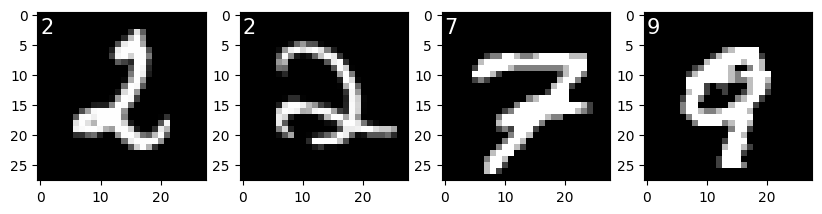

In [10]:
# 4개만 가져와서 그림 그리기
X = X_batched[:4]
y = y_batched[:4]

fig, ax = plt.subplots(figsize=(10,5), nrows=1, ncols=4)

for i in range(4):
    ax[i].imshow(X[i][0], cmap='gray')
    ax[i].text(0, 3, y[i].item(), color='w', fontsize=15)
plt.show()

## Define Model

In [11]:
model = torch.nn.Sequential(
        # conv 2 - linear 2인 모델 작성하기 [+]
        torch.nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, padding=1),
        torch.nn.BatchNorm2d(64),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(kernel_size=2, stride=2), # (N,64,14,14)
                                  # 28*28 -> 14*14 으로 변환하기 위해
                                  # kernel_size=2, stride=2

        torch.nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
        torch.nn.BatchNorm2d(128),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(kernel_size=2, stride=2), # (N,128,7,7),

        torch.nn.Flatten(), # (N,128*7*7)

        torch.nn.Linear(in_features=128*7*7, out_features=256), # (N,256)
        torch.nn.BatchNorm1d(256),
        torch.nn.ReLU(),
        torch.nn.Dropout(), # 완전연결층에 dropout적용

        torch.nn.Linear(in_features=256, out_features=10), # (N,10)
        torch.nn.LogSoftmax(dim=-1)
    )

In [12]:
# 포워드 테스트
out = model(torch.rand(2,1,28,28))
out.shape

torch.Size([2, 10])

## Loss func. and Optimizer

In [13]:
# 손실과 옵티마이저 정의[+]
criterion = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

## Train

In [14]:
model.to(device)

start = time.time()  # 시작 시간 저장

for e in range(epochs):
    model.train()

    for i, d in enumerate(train_loader):
        X = d[0].to(device)
        y = d[1].to(device)

        # 5 steps[+]
        # [1] zerograd
        optimizer.zero_grad()
        # [2] model foward
        score = model(X)
        # [3] loss
        loss = criterion(score, y)
        # [4] loss backward
        loss.backward()
        # [5] update
        optimizer.step()

    # train, test loss and acc.
    model.eval()
    with torch.no_grad():
        corr = 0
        loss_sum = 0.0
        for j, d in enumerate(train_loader):
            X = d[0].to(device)
            y = d[1].to(device)
            out = model(X) # (N, 10) # log softmax
            loss = criterion(out, y)
            loss_sum += loss
            y_pred = torch.argmax(torch.exp(out), dim=-1)
            corr += ((y == y_pred).cpu().numpy().astype(int)).sum()
        train_acc = corr / len(D_train)
        train_loss = loss_sum / (j+1)

        corr = 0
        loss_sum = 0.0
        for j, d in enumerate(test_loader):
            X = d[0].to(device)
            y = d[1].to(device)
            out = model(X) # (N, 10) # log softmax
            loss = criterion(out, y)
            loss_sum += loss
            y_pred = torch.argmax(torch.exp(out), dim=-1)
            corr += ((y == y_pred).cpu().numpy().astype(int)).sum()
        test_acc = corr / len(D_test)
        test_loss = loss_sum / (j+1)

    print(f"EPOCH:{e+1:3d}, Train Loss:{train_loss:.6f}, Train Acc.:{train_acc:.6f}, Test Loss:{test_loss:.6f}, Test Acc.:{test_acc:.6f}")

print("time :", time.time() - start)  # 현재시각 - 시작시간 = 실행 시간

EPOCH:  1, Train Loss:0.036400, Train Acc.:0.989017, Test Loss:0.038337, Test Acc.:0.987100
EPOCH:  2, Train Loss:0.022216, Train Acc.:0.992917, Test Loss:0.029647, Test Acc.:0.991000
EPOCH:  3, Train Loss:0.014702, Train Acc.:0.995800, Test Loss:0.024407, Test Acc.:0.992000
EPOCH:  4, Train Loss:0.010500, Train Acc.:0.996867, Test Loss:0.022738, Test Acc.:0.992000
EPOCH:  5, Train Loss:0.007584, Train Acc.:0.997667, Test Loss:0.021113, Test Acc.:0.992300
EPOCH:  6, Train Loss:0.007343, Train Acc.:0.997733, Test Loss:0.026397, Test Acc.:0.991900
EPOCH:  7, Train Loss:0.004145, Train Acc.:0.998900, Test Loss:0.023425, Test Acc.:0.991700
EPOCH:  8, Train Loss:0.003863, Train Acc.:0.998950, Test Loss:0.019501, Test Acc.:0.993700
EPOCH:  9, Train Loss:0.002705, Train Acc.:0.999283, Test Loss:0.022060, Test Acc.:0.993300
EPOCH: 10, Train Loss:0.002833, Train Acc.:0.999117, Test Loss:0.023087, Test Acc.:0.993900
time : 210.23659253120422
